In [1]:
%run tools.ipynb

In [2]:
def pl_compute(method, ozone_file_name):
    #method = 'm7_m12' # aot40, m7_m12
    #method = 'aot40'
    # relative yield
    fname = '../data/crop/' + ozone_file_name
    ds_ry = xr.open_dataset(fname)
    crop_types = ds_ry['crop'].attrs['comment']
    ry_m = ds_ry[method]
    yl_m = ry_m.copy()
    yl_m[:,:,:] = np.nan # yield loss, initial

    # yield
    fname = '../data/crop/crop_yield_2x2.5.nc'
    ds_yield = xr.open_dataset(fname) # unit: ton/ha

    # yield loss
    for i, icrop in enumerate(crop_types):
        yl_m[i,:,:] = (ds_yield[icrop] / ry_m[i]) - ds_yield[icrop]

    yl_m = yl_m.fillna(0.)
    yl_maize = yl_m[0,:,:] + yl_m[1,:,:]
    yl_rice = yl_m[2,:,:] + yl_m[3,:,:]
    yl_wheat = yl_m[4,:,:] + yl_m[5,:,:]
    yl_soybean = yl_m[6,:,:]

    # harvest area, ton/ha
    fname = '../data/crop/harvest_area.nc'
    ds = xr.open_dataset(fname)

    # production loss, ton
    scale_factor = 1e-6
    pl_maize = yl_maize * ds['maize'] * scale_factor # Mton
    pl_rice = yl_rice * ds['rice']* scale_factor
    pl_wheat = yl_wheat * ds['wheat']* scale_factor
    pl_soybean = yl_soybean * ds['soybean']* scale_factor
    return pl_maize, pl_rice, pl_wheat, pl_soybean


In [3]:

ctr_file = 'ctr_relative_yield.nc'
exp_file = 'geoE_relative_yield.nc'

pl_maize_aot40_ctr,pl_rice_aot40_ctr, pl_wheat_aot40_ctr, pl_soybean_aot40_ctr = pl_compute('aot40', ctr_file)
pl_maize_m_ctr,pl_rice_m_ctr, pl_wheat_m_ctr, pl_soybean_m_ctr = pl_compute('m7_m12', ctr_file)
pl_maize_aot40_exp,pl_rice_aot40_exp, pl_wheat_aot40_exp, pl_soybean_aot40_exp = pl_compute('aot40', exp_file)
pl_maize_m_exp,pl_rice_m_exp, pl_wheat_m_exp, pl_soybean_m_exp = pl_compute('m7_m12', exp_file)

ctr_aot40 = [np.nansum(pl_maize_aot40_ctr.values), np.nansum(pl_rice_aot40_ctr.values), np.nansum(pl_wheat_aot40_ctr.values), np.nansum(pl_soybean_aot40_ctr.values)]
ctr_m = [np.nansum(pl_maize_m_ctr.values), np.nansum(pl_rice_m_ctr.values), np.nansum(pl_wheat_m_ctr.values), np.nansum(pl_soybean_m_ctr.values)]
exp_aot40 = [np.nansum(pl_maize_aot40_exp.values), np.nansum(pl_rice_aot40_exp.values), np.nansum(pl_wheat_aot40_exp.values), np.nansum(pl_soybean_aot40_exp.values)]
exp_m = [np.nansum(pl_maize_m_exp.values), np.nansum(pl_rice_m_exp.values), np.nansum(pl_wheat_m_exp.values), np.nansum(pl_soybean_m_exp.values)]


df = pd.DataFrame(ctr_aot40, columns = ['ctr_aot40'])
df['exp_aot40'] = exp_aot40
df['ctr_m'] = ctr_m
df['exp_m'] = exp_m
df['aot40_per'] = 100*(df['exp_aot40'] - df['ctr_aot40'])/df['ctr_aot40']
df['m_per'] = 100*(df['exp_m'] - df['ctr_m'])/df['ctr_m']
df


,ctr_aot40,exp_aot40,ctr_m,exp_m,aot40_per,m_per
0,38.547162,35.301999,65.751525,61.180816,-8.418682,-6.951487
1,51.631457,48.433159,27.516465,26.112597,-6.194475,-5.101918
2,123.590067,102.575031,29.425412,26.527169,-17.003823,-9.849455
3,25.505401,22.926453,51.284844,48.033633,-10.111382,-6.339515


In [22]:
ds_out_exp = pl_maize_aot40_exp.to_dataset(name = 'maize_pl_aot40')
ds_out_exp['wheat_pl_aot40'] = pl_wheat_aot40_exp
ds_out_exp['soybean_pl_aot40'] = pl_soybean_aot40_exp
ds_out_exp['rice_pl_aot40'] = pl_rice_aot40_exp
ds_out_exp = ds_out_exp.drop('crop')
ds_out_exp.attrs['comment'] = 'production loss using AOT40 exposure metric'
ds_out_exp.attrs['unit'] = 'million tons, magaton, 1e6 ton'

ds_out_exp.to_netcdf('../data/crop/production_loss_aot40_exp.nc')

In [ ]:
ds_out_ctr = pl_maize_aot40_ctr.to_dataset(name = 'maize_pl_aot40')
ds_out_ctr['wheat_pl_aot40'] = pl_wheat_aot40_ctr
ds_out_ctr['soybean_pl_aot40'] = pl_soybean_aot40_ctr
ds_out_ctr['rice_pl_aot40'] = pl_rice_aot40_ctr
ds_out_ctr = ds_out_ctr.drop('crop')
ds_out_ctr.attrs['comment'] = 'production loss using AOT40 exposure metric'
ds_out_ctr.attrs['unit'] = 'million tons, magaton, 1e6 ton'

ds_out_ctr.to_netcdf('../data/crop/production_loss_aot40_ctr.nc')

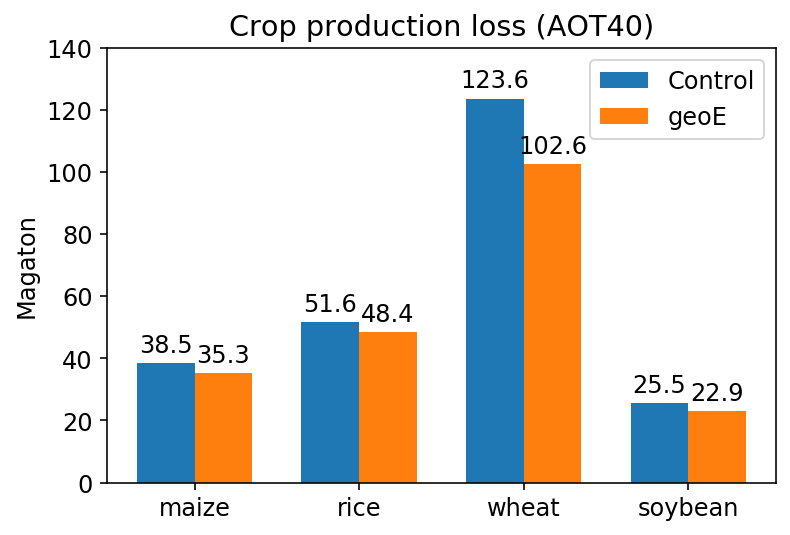

In [4]:

x = np.arange(4)
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
rects1 = ax.bar(x - 0.5*width, df['ctr_aot40'], width, label='Control')
rects2 = ax.bar(x + 0.5*width, df['exp_aot40'], width, label='geoE')
#rects3 = ax.bar(x + width/2, df['ctr_m'], width, label='GCHP_m')
#rects4 = ax.bar(x + 1.5*width, df['exp_m'], width, label='geoE_m')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(['maize', 'rice', 'wheat', 'soybean'])
ax.set_ylim(0,140)
ax.set_ylabel('Magaton')
ax.set_title('Crop production loss (AOT40)')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop/outputs/figures/global/'
fig.savefig(out_dir + 'crop_production_barcharts_aot40.png', dpi = 300, bbox_inches = "tight")


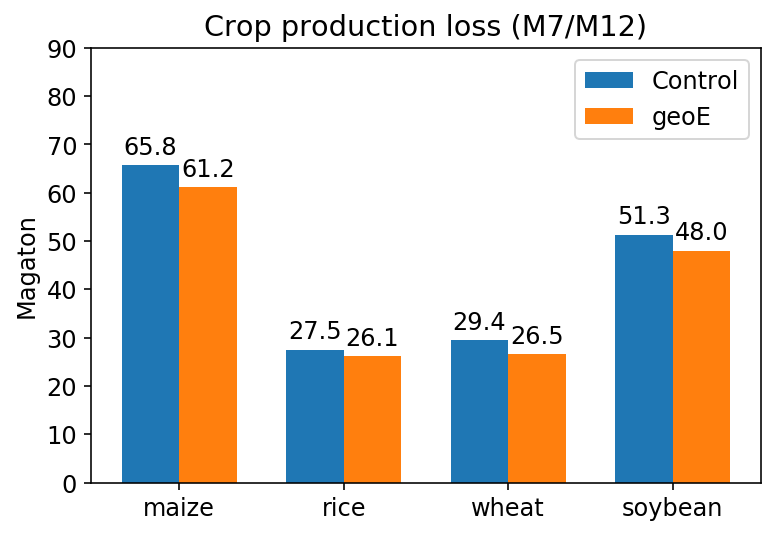

In [5]:

x = np.arange(4)
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
#rects1 = ax.bar(x - 0.5*width, df['ctr_aot40'], width, label='Control')
#rects2 = ax.bar(x + 0.5*width, df['exp_aot40'], width, label='geoE')
rects3 = ax.bar(x - width/2, df['ctr_m'], width, label='Control')
rects4 = ax.bar(x + width/2, df['exp_m'], width, label='geoE')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(['maize', 'rice', 'wheat', 'soybean'])
ax.set_ylim(0,90)
ax.set_ylabel('Magaton')
ax.set_title('Crop production loss (M7/M12)')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects3)
autolabel(rects4)

out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop/outputs/figures/global/'
fig.savefig(out_dir + 'crop_production_barcharts_m.png', dpi = 300, bbox_inches = "tight")


In [6]:
diff_maize_aot40, diff_rice_aot40, diff_wheat_aot40, diff_soybean_aot40 = pl_maize_aot40_exp - pl_maize_aot40_ctr, pl_rice_aot40_exp -  pl_rice_aot40_ctr, pl_wheat_aot40_exp - pl_wheat_aot40_ctr, pl_soybean_aot40_exp - pl_soybean_aot40_ctr 
diff_maize_m, diff_rice_m, diff_wheat_m, diff_soybean_m = pl_maize_m_exp - pl_maize_m_ctr, pl_rice_m_exp -  pl_rice_m_ctr, pl_wheat_m_exp -  pl_wheat_m_ctr, pl_soybean_m_exp - pl_soybean_m_ctr 


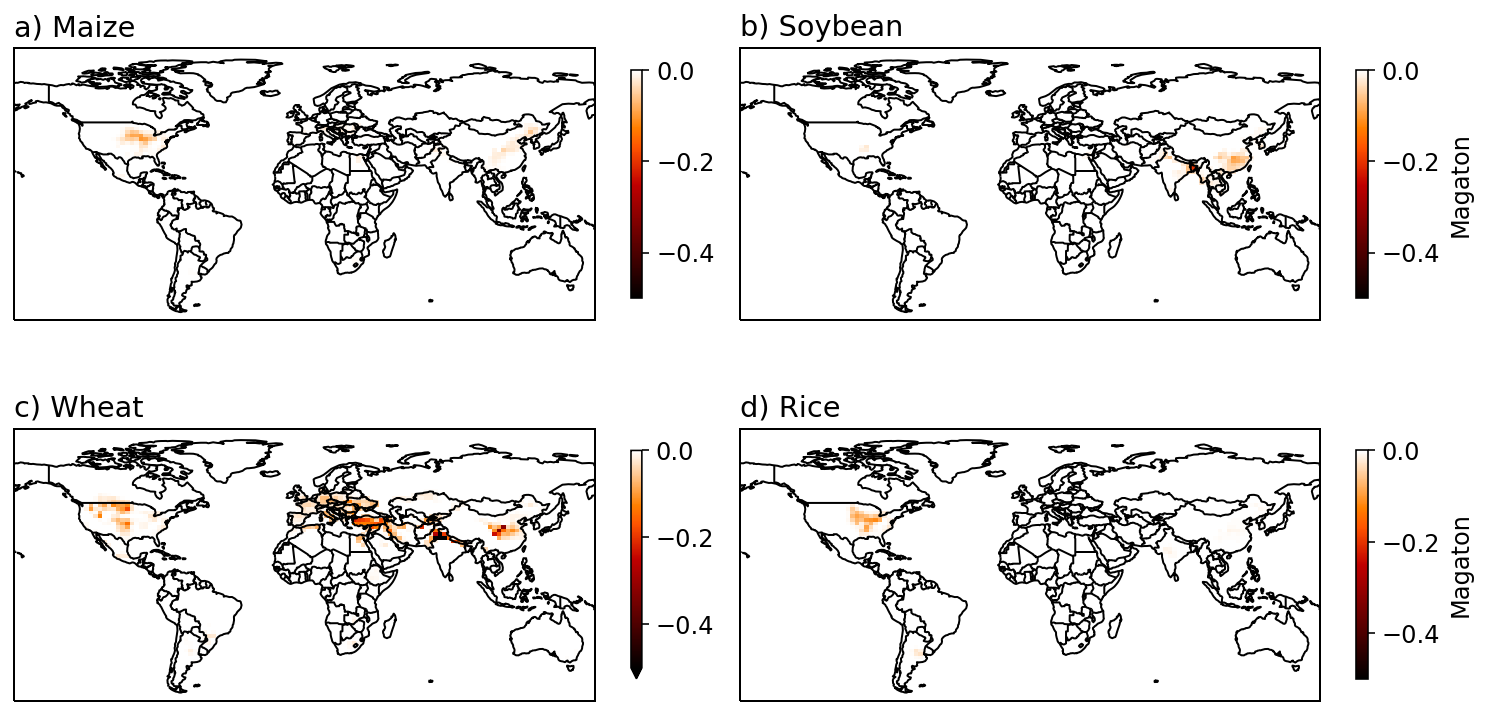

In [7]:
# plot XY range
lon1 = -160
lon2 = 160
lat1 = -60
lat2 = 90
order_crops = ['a) Maize', 'b) Soybean', 'c) Wheat', 'd) Rice']

lim_max = 0
lim_min = -0.5

shrink = 0.6

# figure 1, distribution
fig, axes = plt.subplots(2, 2, 
                             figsize=[13, 7], 
                             subplot_kw={'projection': ccrs.PlateCarree()},
                             gridspec_kw={'hspace': 0, 'wspace': 0})
# before
diff_maize_aot40.plot(ax=axes[0,0],
                  cmap='gist_heat',
                  vmin = lim_min,
                  vmax = lim_max, 
                  add_labels = False,
                  cbar_kwargs={'shrink': shrink})
axes[0,0].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[0,0].set_title(order_crops[0], loc='left')
axes[0,0].coastlines()
#axes[0,0].gridlines(linestyle = '--')
axes[0,0].add_feature(cfeature.BORDERS)

# after
diff_rice_aot40.plot(ax=axes[0,1], 
                cmap='gist_heat', 
                vmin = lim_min,
                vmax = lim_max, 
                cbar_kwargs={'shrink': shrink, 'label': 'Magaton'})
axes[0,1].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[0,1].set_title(' ')
axes[0,1].set_title(order_crops[1], loc='left')
#axes[1].set_title('mean: ' + str(model_mean), loc = 'right')
axes[0,1].coastlines()
#axes[0,1].gridlines(linestyle = '--')
axes[0,1].add_feature(cfeature.BORDERS)

diff_wheat_aot40.plot(ax=axes[1,0],
                  cmap='gist_heat',
                  vmin = lim_min,
                  vmax = lim_max,
                  add_labels = False,
                  cbar_kwargs={'shrink': shrink})
axes[1,0].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[1,0].set_title(order_crops[2], loc='left')
#axes[0].set_title('mean: ' + str(obs_mean), loc = 'right')
axes[1,0].coastlines()
#axes[1,0].gridlines(linestyle = '--')
axes[1,0].add_feature(cfeature.BORDERS)

# after
diff_soybean_aot40.plot(ax=axes[1,1], 
                cmap='gist_heat',
                vmin = lim_min,
                vmax = lim_max, 
                cbar_kwargs={'shrink': shrink, 'label': 'Magaton'})
axes[1,1].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[1,1].set_title(' ')
axes[1,1].set_title(order_crops[3], loc='left')
axes[1,1].coastlines()
axes[1,1].add_feature(cfeature.BORDERS)

# save figure
out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop/outputs/figures/global/'
fig.savefig(out_dir + 'crop_production_diff_aot.png', dpi = 300, bbox_inches = "tight")


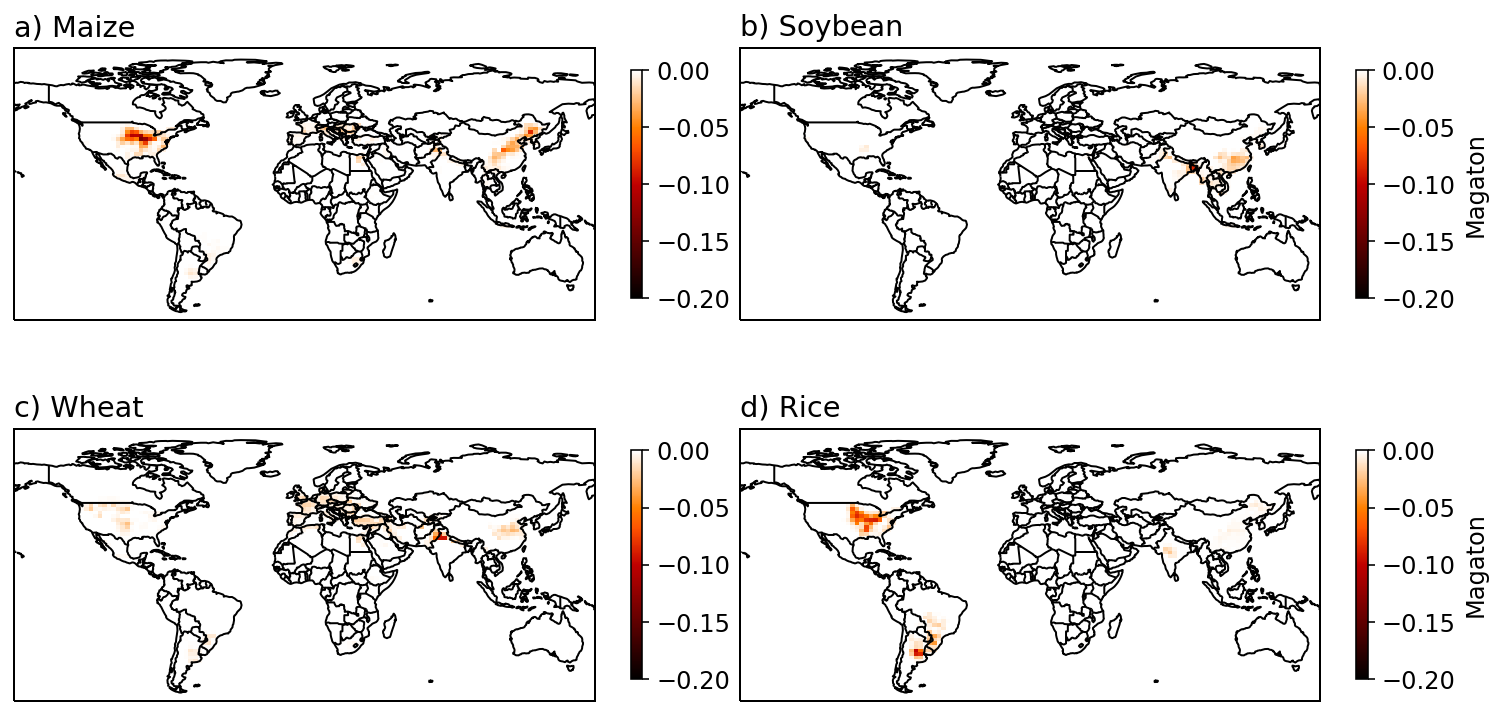

In [8]:
# plot XY range
lon1 = -160
lon2 = 160
lat1 = -60
lat2 = 90
order_crops = ['a) Maize', 'b) Soybean', 'c) Wheat', 'd) Rice']

lim_max = 0
lim_min = -0.2

shrink = 0.6

# figure 1, distribution
fig, axes = plt.subplots(2, 2, 
                             figsize=[13, 7], 
                             subplot_kw={'projection': ccrs.PlateCarree()},
                             gridspec_kw={'hspace': 0, 'wspace': 0})
# before
diff_maize_m.plot(ax=axes[0,0],
                  cmap='gist_heat',
                  vmin = lim_min,
                  vmax = lim_max, 
                  add_labels = False,
                  cbar_kwargs={'shrink': shrink})
axes[0,0].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[0,0].set_title(order_crops[0], loc='left')
axes[0,0].coastlines()
#axes[0,0].gridlines(linestyle = '--')
axes[0,0].add_feature(cfeature.BORDERS)

# after
diff_rice_m.plot(ax=axes[0,1], 
                cmap='gist_heat', 
                vmin = lim_min,
                vmax = lim_max, 
                cbar_kwargs={'shrink': shrink, 'label': 'Magaton'})
axes[0,1].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[0,1].set_title(' ')
axes[0,1].set_title(order_crops[1], loc='left')
#axes[1].set_title('mean: ' + str(model_mean), loc = 'right')
axes[0,1].coastlines()
#axes[0,1].gridlines(linestyle = '--')
axes[0,1].add_feature(cfeature.BORDERS)

diff_wheat_m.plot(ax=axes[1,0],
                  cmap='gist_heat',
                  vmin = lim_min,
                  vmax = lim_max,
                  add_labels = False,
                  cbar_kwargs={'shrink': shrink})
axes[1,0].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[1,0].set_title(order_crops[2], loc='left')
#axes[0].set_title('mean: ' + str(obs_mean), loc = 'right')
axes[1,0].coastlines()
#axes[1,0].gridlines(linestyle = '--')
axes[1,0].add_feature(cfeature.BORDERS)

# after
diff_soybean_m.plot(ax=axes[1,1], 
                cmap='gist_heat',
                vmin = lim_min,
                vmax = lim_max, 
                cbar_kwargs={'shrink': shrink, 'label': 'Magaton'})
axes[1,1].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[1,1].set_title(' ')
axes[1,1].set_title(order_crops[3], loc='left')
axes[1,1].coastlines()
axes[1,1].add_feature(cfeature.BORDERS)

# save figure
out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop/outputs/figures/global/'
fig.savefig(out_dir + 'crop_production_diff_m.png', dpi = 300, bbox_inches = "tight")


In [9]:
# energy loss
def el(a,b,c,d):
    el_maize = a * 3.65 # 1e6 kcal
    el_rice = b * 3.63
    el_wheat = c * 3.34
    el_soybean = d * 4.46
    
    el_total = el_maize.sum().values + el_rice.sum().values + el_wheat.sum().values + el_soybean.sum().values
    print(el_total)
    print('Total energy loss due to ozone:', "{:.2f}".format((el_total*1e6)*1e-15), '*1e15 kcal')



In [10]:
el(pl_maize_aot40_ctr,pl_rice_aot40_ctr, pl_wheat_aot40_ctr, pl_soybean_aot40_ctr)

854.6642410683219
Total energy loss due to ozone: 0.00 *1e15 kcal
